# FunOS module init analysis 

In [1]:

# This is a notebook that generates a chart of module init time. 
# This notebook shows the module init time chart.

# Input:
#     - raw log file: load through config file

# Config file:
#    - config file: `funos_module_init_analysis_config.yml` in the same directory as this notebook


In [2]:
# *NOTE*: run this command to clean output cell and meta data.
# $ nb-clean clean ./funos_module_init_analysis.ipynb 

In [3]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from typing import Tuple
import yaml
import json
import os
import logging

%matplotlib inline

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

#https://stackoverflow.com/questions/36288670/how-to-programmatically-generate-markdown-output-in-jupyter-notebooks
from IPython.display import display, Markdown, Latex

In [4]:
try:
    from funos_module_init_time import *
    from funos_module_init_time_plot import plot_module_time_chart
except ImportError:
    print("Import error")

## Load config

In [5]:
# load config file
current_path = os.getcwd()
print("current directory is: "+current_path)

config_file = "funos_module_init_analysis_config.yml"
path_to_yaml = os.path.join(current_path, config_file)
print("path_to_config_file "+path_to_yaml)
try:
    with open (path_to_yaml, 'r') as c_file:
        config = yaml.safe_load(c_file)
except Exception as e:
    print('Error reading the config file at {} : {}'.format(path_to_yaml, e))

current directory is: /Users/insop/Projects/Fng/FunTools/data_analysis
path_to_config_file /Users/insop/Projects/Fng/FunTools/data_analysis/funos_module_init_analysis_config.yml


In [6]:
# setup the config variables
input_file_url = config["file_names"]["input_file_url"]

## Notebook summary

In [7]:

note_str = "This page summarizes the FunOS modules init time line.\n\n"
display(Markdown(note_str))


This page summarizes the FunOS modules init time line.



## Module and notif init file loading

In [8]:
# A logger for this file
logger = logging.getLogger(__name__)


In [9]:
# load config file
current_path = os.getcwd()
note_str = "current directory is: {}\n\n".format(current_path)
display(Markdown(note_str))

note_str = "INPUT_FILE_URL: [{}]({})\n\n".format(input_file_url, input_file_url)
display(Markdown(note_str))

fun_module_notif_init_df, result = process_module_notif_init_data(
    file_name_url=input_file_url, logger=logger, working_dir=current_path
)

note_str = "### Module init time summary\n\n"
display(Markdown(note_str))

tmp_df = pd.DataFrame(result, index=[0])
display(tmp_df.round())
del tmp_df

current directory is: /Users/insop/Projects/Fng/FunTools/data_analysis



INPUT_FILE_URL: [http://palladium-jobs.fungible.local:8080/job/4731935/raw_file/odp/uartout0.0.txt](http://palladium-jobs.fungible.local:8080/job/4731935/raw_file/odp/uartout0.0.txt)



> /Users/insop/Projects/Fng/FunTools/data_analysis/funos_module_init_time.py(392)_get_perf_stat()
    390     import pdb;pdb.set_trace()
    391 
--> 392     del df
    393 
    394     return result



### Module init time summary



,longest_duration_ns,longest_duration_id,total_duration_ns
0,2.667413e+09,rcnvme-init,3.858871e+10


## Plot all modules and notif init

The following chart shows the modules and notification init durations and timelines.



**NOTE**: When the duration is less than a threshold (26674130 ns), the module duration is depicted as the threshold duration so that it can be seen in the chart.



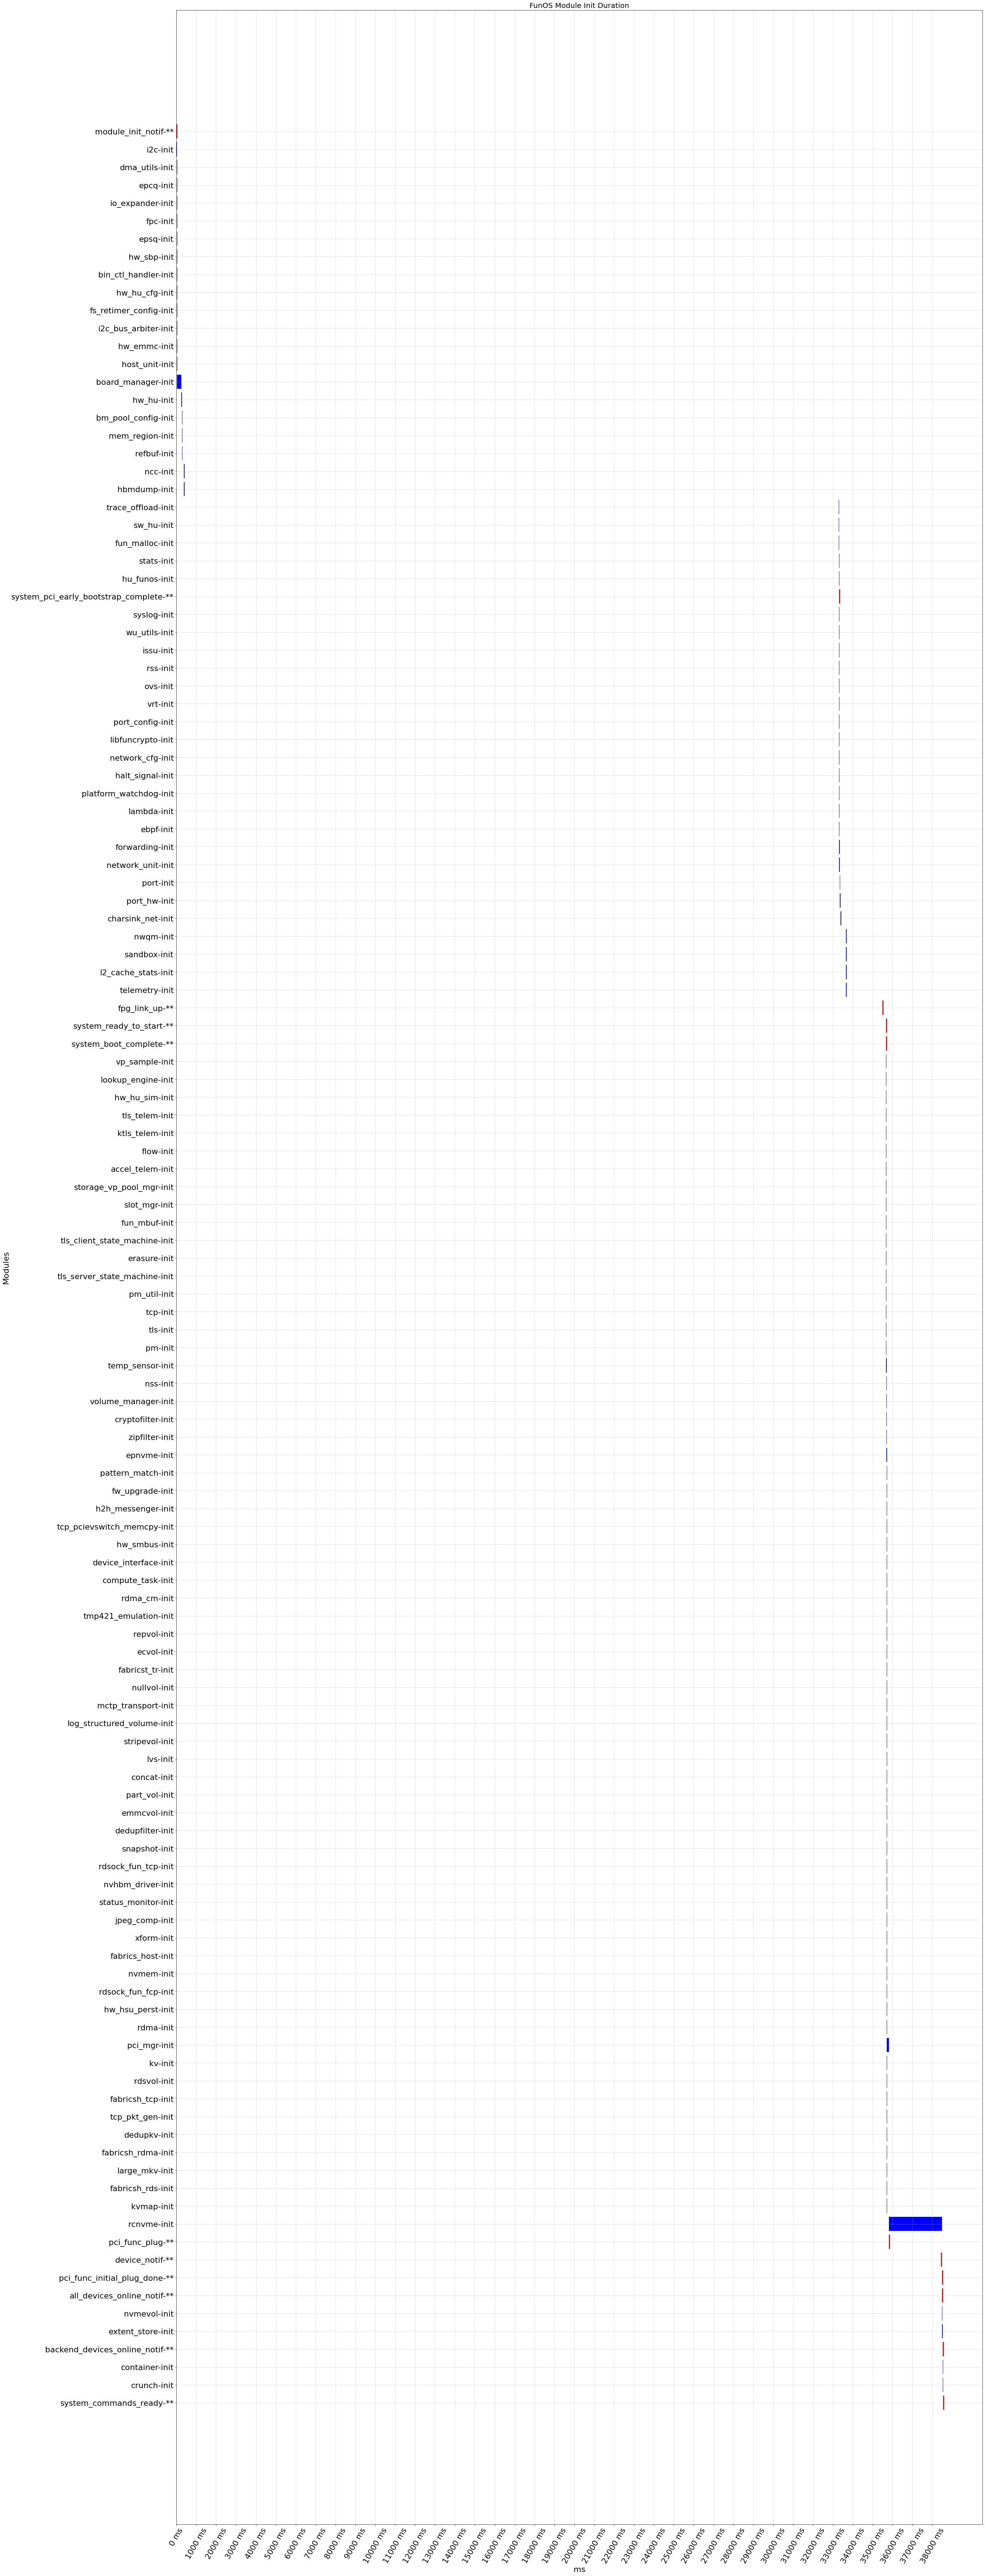

In [10]:
# MAIN CALLS
# plot the events

note_str = "The following chart shows the modules and notification init durations and timelines.\n\n"
display(Markdown(note_str))

threshold_collapse = get_duration_threshold(fun_module_notif_init_df, threshold=0.01)

note_str = "**NOTE**: When the duration is less than a threshold ({} ns), the module duration is depicted as the threshold duration so that it can be seen in the chart.\n\n".format(int(threshold_collapse))

display(Markdown(note_str))

working_dir = "."
full_module_notif_chart = os.path.join(working_dir, "fun_module_notif_init_chart.png")
plot_module_time_chart(fun_module_notif_init_df, disp_granualarity_ms=1000, min_duration=threshold_collapse, debug=False,logger=logger)

## Collapsed Plot all modules and notif init

To visualize it better, modules are near each other and shorter than the threshold are collapsed together in the following chart



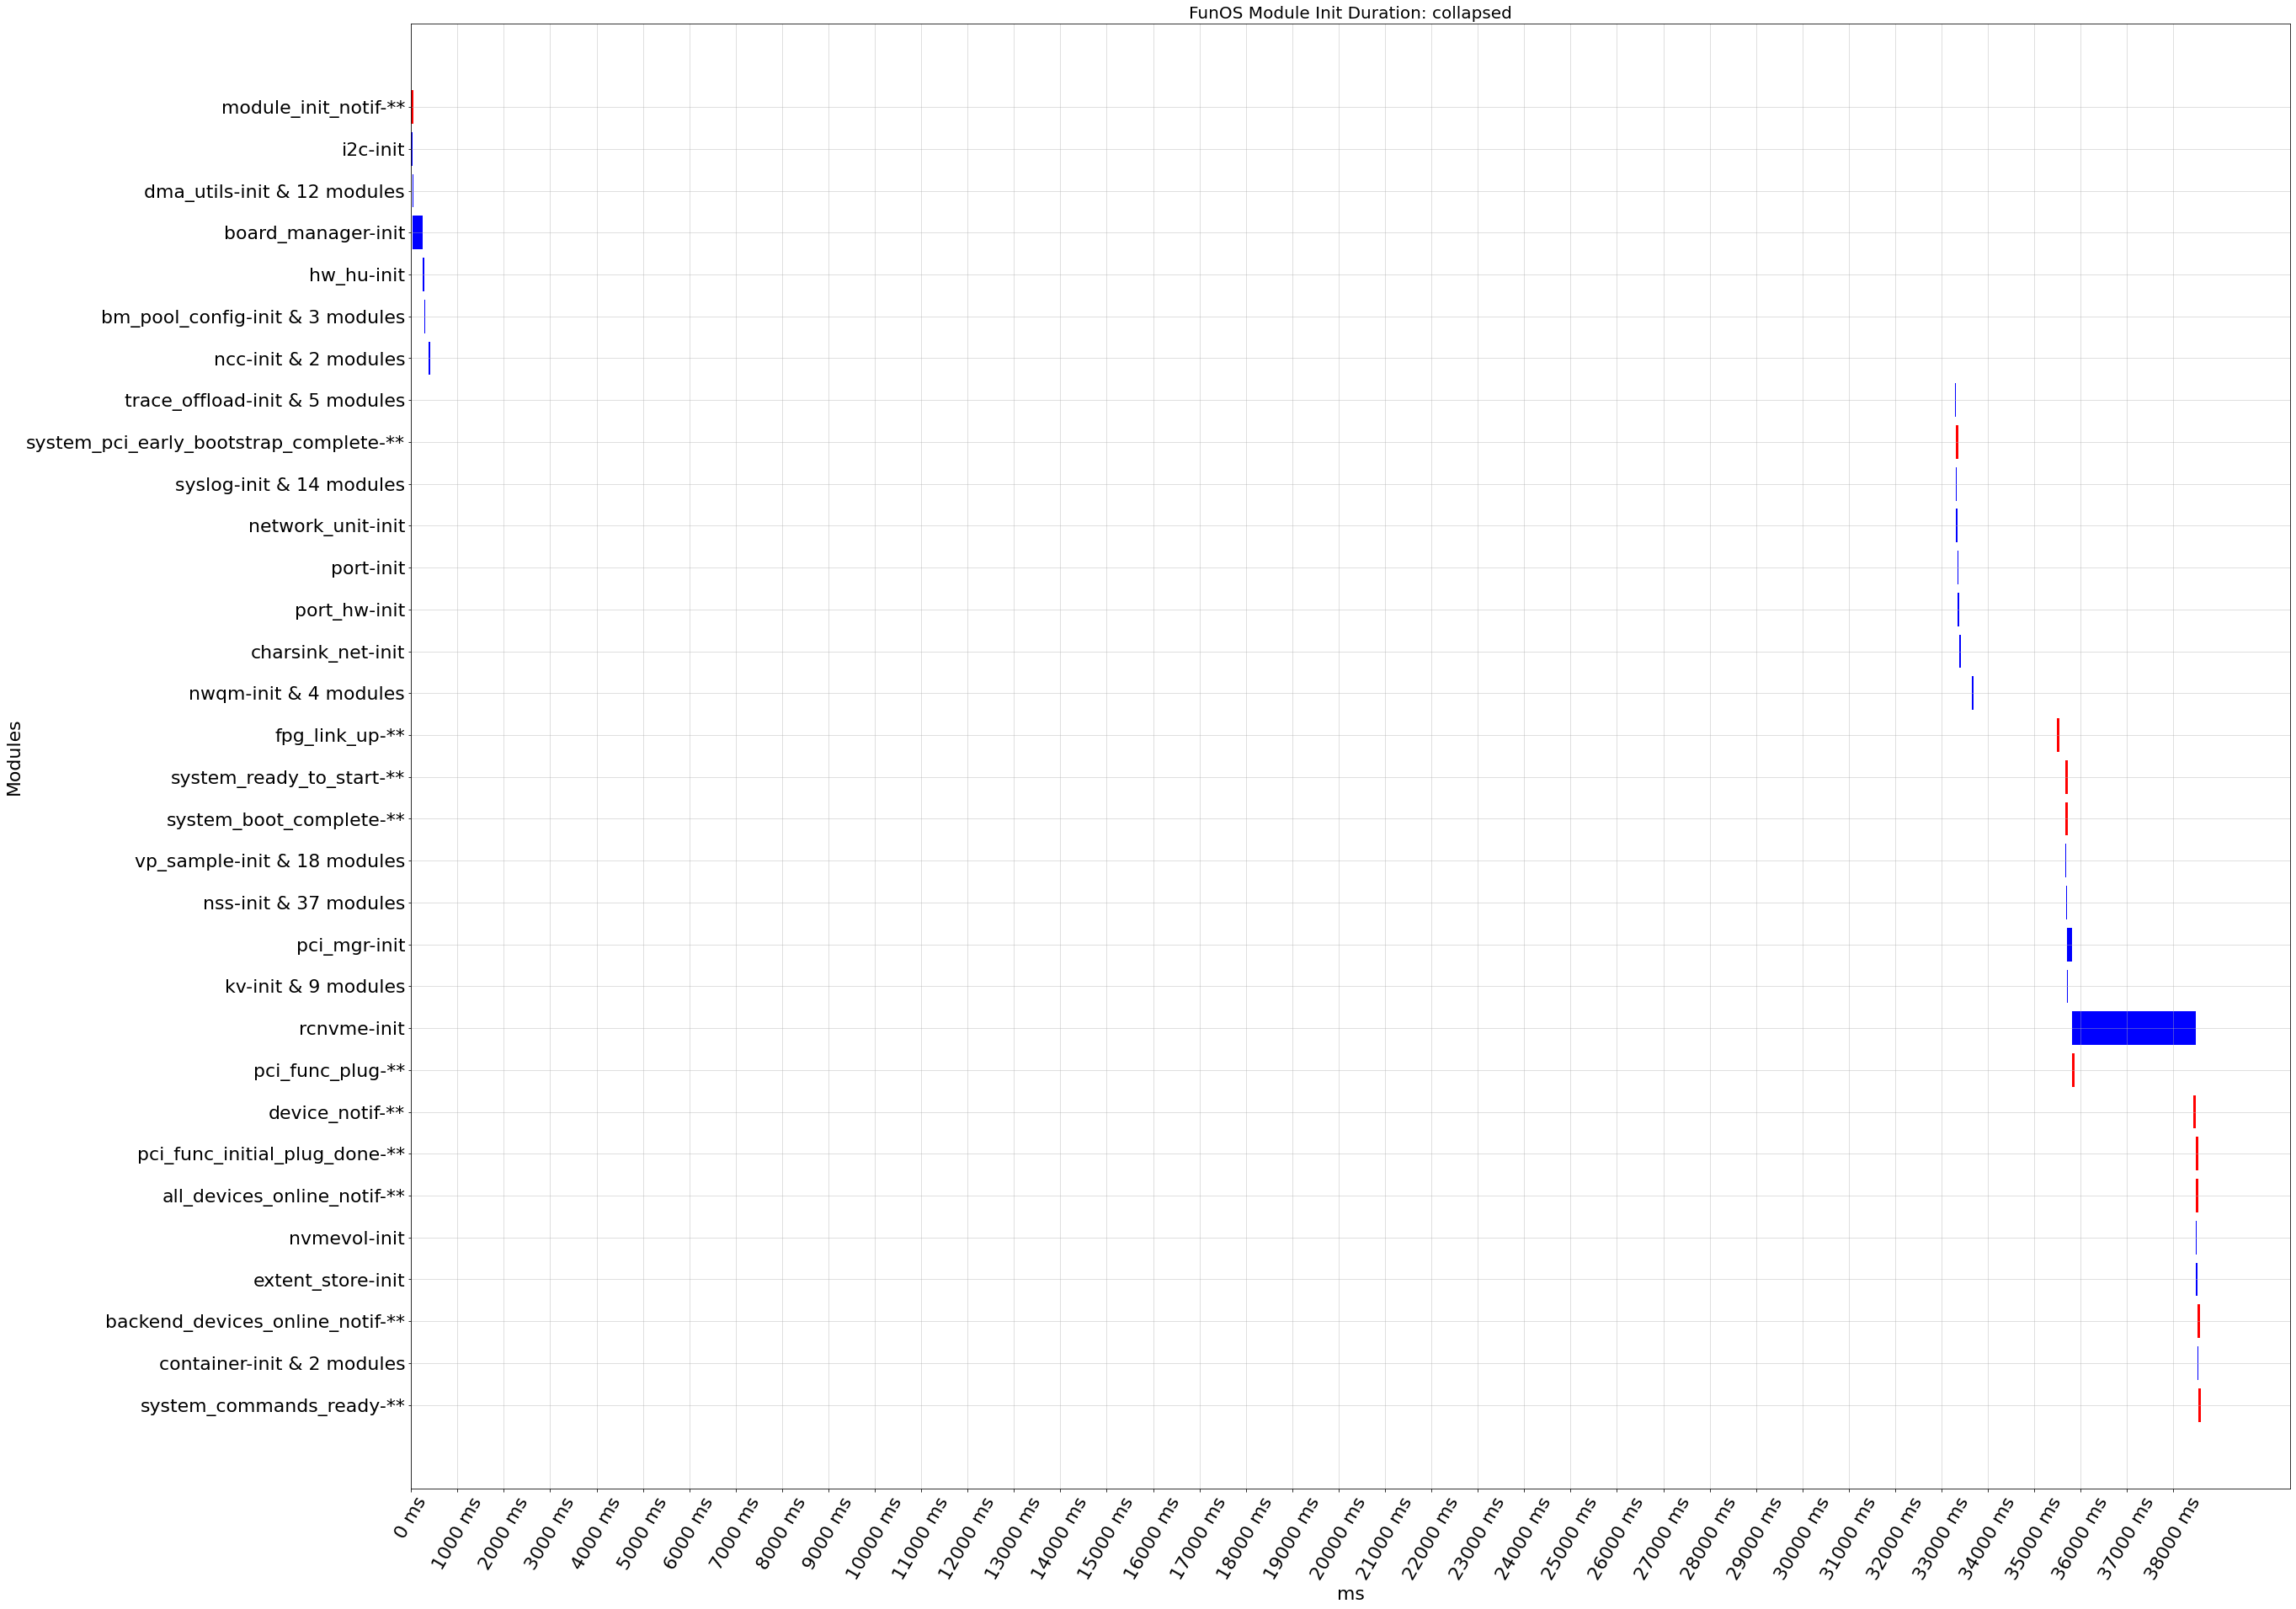

INFO:utils:Collapsed module group report (threshold time of 26674130.0 ns):
group_0**(1): ['module_init_notif-**']
group_1(1): ['i2c-init']
group_2(12): ['dma_utils-init', 'epcq-init', 'io_expander-init', 'fpc-init', 'epsq-init', 'hw_sbp-init', 'bin_ctl_handler-init', 'hw_hu_cfg-init', 'fs_retimer_config-init', 'i2c_bus_arbiter-init', 'hw_emmc-init', 'host_unit-init']
group_3(1): ['board_manager-init']
group_4(1): ['hw_hu-init']
group_5(3): ['bm_pool_config-init', 'mem_region-init', 'refbuf-init']
group_6(2): ['ncc-init', 'hbmdump-init']
group_7(5): ['trace_offload-init', 'sw_hu-init', 'fun_malloc-init', 'stats-init', 'hu_funos-init']
group_8**(1): ['system_pci_early_bootstrap_complete-**']
group_9(14): ['syslog-init', 'wu_utils-init', 'issu-init', 'rss-init', 'ovs-init', 'vrt-init', 'port_config-init', 'libfuncrypto-init', 'network_cfg-init', 'halt_signal-init', 'platform_watchdog-init', 'lambda-init', 'ebpf-init', 'forwarding-init']
group_10(1): ['network_unit-init']
group_11(1): ['p

#### Collapsed group description:



- Notificaitons are in bold



- `group_number(number of modules in this group): [modules in this group]`





Collapsed module group report (threshold time of 26674130.0 ns):

========================

group_0**(1): ['module_init_notif-**']

group_1(1): ['i2c-init']

group_2(12): ['dma_utils-init', 'epcq-init', 'io_expander-init', 'fpc-init', 'epsq-init', 'hw_sbp-init', 'bin_ctl_handler-init', 'hw_hu_cfg-init', 'fs_retimer_config-init', 'i2c_bus_arbiter-init', 'hw_emmc-init', 'host_unit-init']

group_3(1): ['board_manager-init']

group_4(1): ['hw_hu-init']

group_5(3): ['bm_pool_config-init', 'mem_region-init', 'refbuf-init']

group_6(2): ['ncc-init', 'hbmdump-init']

group_7(5): ['trace_offload-init', 'sw_hu-init', 'fun_malloc-init', 'stats-init', 'hu_funos-init']

group_8**(1): ['system_pci_early_bootstrap_complete-**']

group_9(14): ['syslog-init', 'wu_utils-init', 'issu-init', 'rss-init', 'ovs-init', 'vrt-init', 'port_config-init', 'libfuncrypto-init', 'network_cfg-init', 'halt_signal-init', 'platform_watchdog-init', 'lambda-init', 'ebpf-init', 'forwarding-init']

group_10(1): ['network_unit-init']

group_11(1): ['port-init']

group_12(1): ['port_hw-init']

group_13(1): ['charsink_net-init']

group_14(4): ['nwqm-init', 'sandbox-init', 'l2_cache_stats-init', 'telemetry-init']

group_15**(1): ['fpg_link_up-**']

group_16**(1): ['system_ready_to_start-**']

group_17**(1): ['system_boot_complete-**']

group_18(18): ['vp_sample-init', 'lookup_engine-init', 'hw_hu_sim-init', 'tls_telem-init', 'ktls_telem-init', 'flow-init', 'accel_telem-init', 'storage_vp_pool_mgr-init', 'slot_mgr-init', 'fun_mbuf-init', 'tls_client_state_machine-init', 'erasure-init', 'tls_server_state_machine-init', 'pm_util-init', 'tcp-init', 'tls-init', 'pm-init', 'temp_sensor-init']

group_19(37): ['nss-init', 'volume_manager-init', 'cryptofilter-init', 'zipfilter-init', 'epnvme-init', 'pattern_match-init', 'fw_upgrade-init', 'h2h_messenger-init', 'tcp_pcievswitch_memcpy-init', 'hw_smbus-init', 'device_interface-init', 'compute_task-init', 'rdma_cm-init', 'tmp421_emulation-init', 'repvol-init', 'ecvol-init', 'fabricst_tr-init', 'nullvol-init', 'mctp_transport-init', 'log_structured_volume-init', 'stripevol-init', 'lvs-init', 'concat-init', 'part_vol-init', 'emmcvol-init', 'dedupfilter-init', 'snapshot-init', 'rdsock_fun_tcp-init', 'nvhbm_driver-init', 'status_monitor-init', 'jpeg_comp-init', 'xform-init', 'fabrics_host-init', 'nvmem-init', 'rdsock_fun_fcp-init', 'hw_hsu_perst-init', 'rdma-init']

group_20(1): ['pci_mgr-init']

group_21(9): ['kv-init', 'rdsvol-init', 'fabricsh_tcp-init', 'tcp_pkt_gen-init', 'dedupkv-init', 'fabricsh_rdma-init', 'large_mkv-init', 'fabricsh_rds-init', 'kvmap-init']

group_22(1): ['rcnvme-init']

group_23**(1): ['pci_func_plug-**']

group_24**(1): ['device_notif-**']

group_25**(1): ['pci_func_initial_plug_done-**']

group_26**(1): ['all_devices_online_notif-**']

group_27(1): ['nvmevol-init']

group_28(1): ['extent_store-init']

group_29**(1): ['backend_devices_online_notif-**']

group_30(2): ['container-init', 'crunch-init']

group_31**(1): ['system_commands_ready-**']



In [11]:
# MAIN CALLS
# plot the events

note_str = "To visualize it better, modules are near each other and shorter than the threshold are collapsed together in the following chart\n\n"
display(Markdown(note_str))

fun_module_notif_init_df_collapsed, group_table_module_notif = get_collapsed_df(fun_module_notif_init_df, threshold_collapse, debug=False)

working_dir = "."

save_file_name = os.path.join(working_dir, "fun_module_notif_init_df_collapsed.png")

plot_module_time_chart(fun_module_notif_init_df_collapsed, disp_granualarity_ms=1000, debug=False, group_table=group_table_module_notif, min_duration=threshold_collapse, logger=logger)

output = print_group_table(group_table_module_notif, threshold=threshold_collapse, save_file_name=save_file_name)

note_str = "#### Collapsed group description:\n\n"
display(Markdown(note_str))

note_str = "- Notificaitons are in bold\n\n"
display(Markdown(note_str))

note_str = "- `group_number(number of modules in this group): [modules in this group]`\n\n\n\n"
display(Markdown(note_str))

# replace \n with \n\n to display in markdown
output = output.replace("\n", "\n\n")
display(Markdown(output))